# Analyze A/B Test Results 


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape[0]

294478

In [4]:
df.user_id.nunique()

290584

In [5]:
df.converted.mean()*100

11.96591935560551

In [6]:
df.query('(group == "treatment" and landing_page=="old_page") or (group == "control" and landing_page=="new_page")')

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
...,...,...,...,...,...
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0
294252,892498,2017-01-22 01:11:10.463211,treatment,old_page,0
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0


In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [4]:
df2 = df.query('(group == "treatment" and landing_page=="new_page") or (group == "control" and landing_page=="old_page")')

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2.user_id.nunique()

290584

In [11]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
df2.query('user_id==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [5]:
df2.drop(2893, inplace=True)

C:\Users\Aziz\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
np.round(df2.converted.mean(),4)

0.1196

In [15]:
np.round(df2[df2.group=="control"].converted.mean(),4)

0.1204

In [16]:
np.round(df2[df2.group=="treatment"].converted.mean(),4)

0.1188

In [18]:
obs_diff = np.round(df2[df2.group=="control"].converted.mean(),4) - np.round(df2[df2.group=="treatment"].converted.mean(),4)
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.

In [20]:
np.round(df2[df2["landing_page"]=="new_page"].shape[0]/df2.shape[0],4)

0.5001

**Not enough evidence.**


<a id='ab_test'></a>
## Part II - A/B Test

**H0: Pold>=Pnew**

**H1: Pold<Pnew**

In [9]:
p_new =df2.converted.mean()
np.round(p_new,4)


0.1196

In [10]:
p_old = p_new
np.round(p_old,4)


0.1196

In [11]:
n_new = df2[df2["landing_page"] == "new_page"].count()[0]
n_new

145310

In [12]:
n_old = df2[df2["landing_page"] == "old_page"].count()[0]
n_old

145274

In [28]:
new_page_converted = np.random.choice(a=[1,0],size=n_new, p = [p_new,1-p_new])
# Simulate a Sample for the treatment Group

In [29]:
old_page_converted = np.random.choice(a=[1,0],size=n_old, p = [p_old,1-p_old])
# Simulate a Sample for the control Group

In [30]:
diff = new_page_converted.mean()- old_page_converted.mean()
diff

0.0005210305292958906

In [32]:
# Sampling distribution 
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice(a=[1,0],size=n_new, p = [p_new,1-p_new])
    old_page_converted = np.random.choice(a=[1,0],size=n_old, p = [p_old,1-p_old])
    diff = new_page_converted.mean()- old_page_converted.mean()
    p_diffs.append(diff)


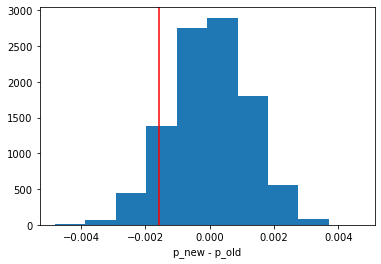

In [35]:
obs_diff = df2[df2["landing_page"] == "new_page"].converted.mean() - df2[df2["landing_page"] == "old_page"].converted.mean()
plt.hist(p_diffs)
plt.xlabel("p_new - p_old")
plt.axvline(x=obs_diff,color="red")

0.9041

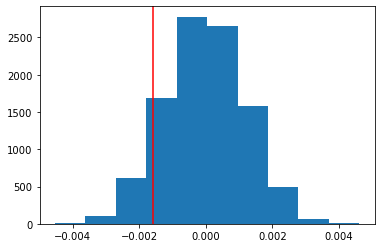

In [36]:
nulls=  np.random.normal(0, np.std(p_diffs), 10000)
plt.hist(nulls)
plt.axvline(x=obs_diff,color="red")
test = (p_diffs>obs_diff).mean()
test

>**p value.**
>**we fail to reject null hypothesis because the p-value is large.**

In [40]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old =df2.query('group=="control" and converted ==1').count()[0]

# number of conversions with the new_page
convert_new = df2.query('group=="treatment" and converted ==1').count()[0]

# number of individuals who were shown the old_page
n_old = df2.query('group=="control"').count()[0]

# number of individuals who received new_page
n_new = df2.query('group=="treatment"').count()[0]



count_array=np.array([convert_new,convert_old])
nobs_array= np.array([n_new,n_old])

In [42]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count=count_array,nobs=nobs_array,alternative="larger")
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


>**the scores are similar means that we fail to reject null hypothesis because the z-score isn't in the rejection area.**

<a id='regression'></a>
### Part III - A regression approach

>**Logistic regression for classification.**

In [46]:
df3 = df2.copy()

In [55]:
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [56]:
df3[['ab_page', 'old_page']] = pd.get_dummies(df3['landing_page'])
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


In [57]:
df3 = df3.drop('old_page', axis=1)
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [60]:
df3['intercept'] = 1

In [64]:
import statsmodels.api as sm
logistic_model = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
results = logistic_model.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [65]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 23 Jan 2023   Pseudo R-squ.:               8.077e-06
Time:                        08:47:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

ab_test isn't statistically significant for prediction.

**The null and alternative hypotheses for the regression model are different than we have from Part2**

**here in logistic regression we assume the H0: Pnew = Pold and H1: Pnew != Pold**

>**More factors = more precision in our analysis but we always want to choose factors that's statistically significant.**

In [68]:
# Read the countries.csv
countries_df = pd.read_csv('./countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [70]:
# Join with the df2 dataframe
df_merged = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')
df_merged.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [72]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])

In [73]:
df_merged.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [79]:
logistic_model_2 = sm.Logit(df_merged['converted'],df_merged[['intercept', 'ab_page', 'US', 'UK']])
results_2 = logistic_model_2.fit()
results_2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 23 Jan 2023   Pseudo R-squ.:               2.323e-05
Time:                        09:47:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [87]:
np.exp(0.0408), np.exp(0.0506)

(1.0416437559600236, 1.0519020483004984)

In [88]:
# Fit your model, and summarize the results
df_merged['UK_ab_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged['US_ab_page'] = df_merged['US'] * df_merged['ab_page']
df_merged.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [83]:
logistic_model_3 = sm.Logit(df_merged['converted'],df_merged[['intercept', 'ab_page', 'US', 'UK','UK_ab_page','US_ab_page']])
results_3 = logistic_model_3.fit()
results_3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 23 Jan 2023   Pseudo R-squ.:               3.482e-05
Time:                        09:58:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

US are 1.04 more likely to convert and UK is 1.05 times than CA.
however, countries columns have no significance on conversion (p-value isn't statistically significant <0.05)

We fail to reject the null so we predict the (OLD PAGE) to have more conversions.

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'NEWAnalyze_ab_test_results_notebook.ipynb'])

4294967295